In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = [10,10]

### Load data from pickled files

In [2]:
import pickle

run_nr=898989
number_of_parallel_runs=10

results = {}
for no in range(number_of_parallel_runs):
    path = "output/benchmark/{run_nr}/results_{no}.pickle".format(run_nr=run_nr,no=no)
    try:
        with open(path, 'rb') as handle:
            results = {**results,**pickle.load(handle)} # combine dicts from different parallel runs
    except:
        print("Error!")
        pass
        
results_original = results.copy()

print(len(results))

25400


### Helper functions

In [3]:
from collections import defaultdict
    
def extract_by_graph(results):
    graph_dict= defaultdict(list)
    
    graph_prefixes = ["geom_graph","householdsuper","erdos_renyi","barabasi","grid_2d","newman","complete","regular"]
    
    for result_item in results.items():
        ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) = result_item
        for prefix in graph_prefixes:
            if graph_name.startswith(prefix):
                graph_dict[prefix].append(result_item)
                continue
    
    return graph_dict

def extract_by_baseline(results):
    baseline_dict= defaultdict(list)
    
    for result_item in results.items():
        ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) = result_item
        baseline_dict[baseline_name].append(result_item)
    
    return baseline_dict

# Information about the graphs
## This section visualizes properties of the graphs.

#### Num nodes vs num edges

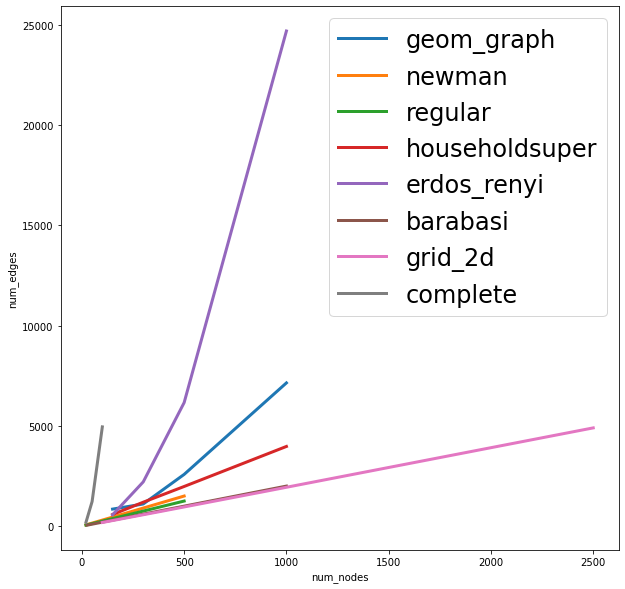

In [4]:
graph_dict = extract_by_graph(results)
import numpy as np
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    data = [(g["num_nodes"],g["num_edges"]) for g in graph_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=graph_prefix,  linewidth=3,)
    
plt.legend(prop={'size': 24})
plt.xlabel('num_nodes')
plt.ylabel('num_edges')
plt.show()

#### graph type to properties

In [5]:
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    if graph_prefix == "complete":
        continue
    print(f'Mean degree for {graph_prefix}:{np.mean([g["degree_mean"] for g in graph_data_list])}')
print("##########################")
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    print(f'Average shortest path length for {graph_prefix}:{np.mean([g["average_shortest_path_length"] for g in graph_data_list])}')
print("##########################")    
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    print(f'Mean average clustering for {graph_prefix}:{np.mean([g["average_clustering"] for g in graph_data_list])}')

Mean degree for geom_graph:10.77361038961039
Mean degree for newman:6.0
Mean degree for regular:5.0
Mean degree for householdsuper:7.879000000000001
Mean degree for erdos_renyi:24.068666666666665
Mean degree for barabasi:3.897333333333334
Mean degree for grid_2d:3.7966666666666673
##########################
Average shortest path length for geom_graph:8.02410612033941
Average shortest path length for newman:3.2737724980359504
Average shortest path length for regular:3.060288157474074
Average shortest path length for householdsuper:2.962269023699737
Average shortest path length for erdos_renyi:2.3399189718083067
Average shortest path length for barabasi:3.2130917798534844
Average shortest path length for grid_2d:18.333333333333336
Average shortest path length for complete:1.0
##########################
Mean average clustering for geom_graph:0.630045831590507
Mean average clustering for newman:0.34313968253968274
Mean average clustering for regular:0.04644000000000002
Mean average cluster

# Comparing the baselines

In [6]:
baseline_dict = extract_by_baseline(results)

## Information about the baselines: Speed

#### Number of nodes vs duration

Median duration for baseline closeness: 0.21821796894073486
Median duration for baseline betweenness: 0.2076207399368286
Median duration for baseline PersPageRank: 0.06626474857330322
Median duration for baseline PageRank: 0.03929626941680908
Median duration for baseline davaFast: 0.028973817825317383
Median duration for baseline EVcentrality: 0.012064814567565918
Median duration for baseline None: 0.006631135940551758
Median duration for baseline random: 0.005487799644470215
Median duration for baseline degree: 0.005425572395324707


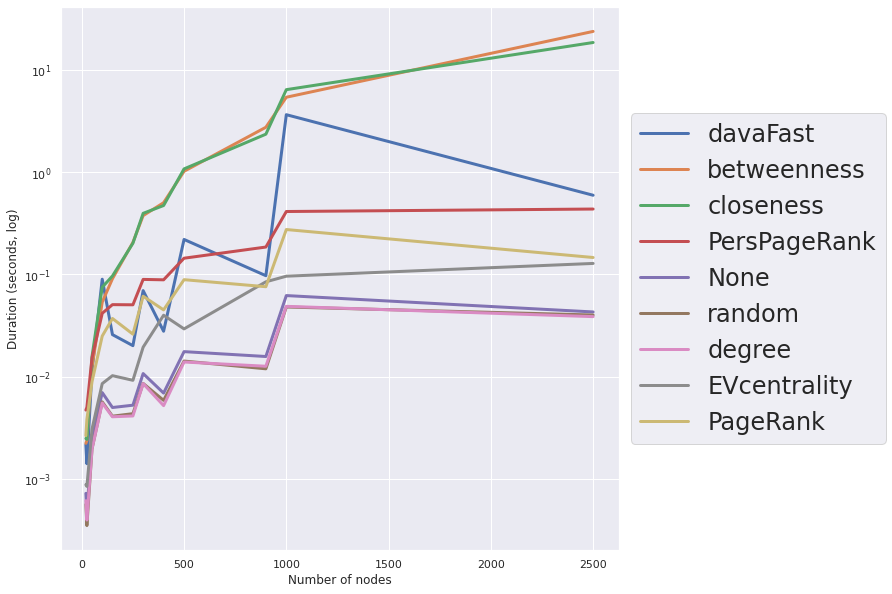

In [7]:
import seaborn as sns
sns.set()
#plt.style.use('ggplot')
avg_durations = {}
plt.clf()
for (baseline_name, result_item_list) in baseline_dict.items():
    if baseline_name=="Simba":
        continue
    result_data_list = [ri[1] for ri in result_item_list]
    
    size_to_dur = defaultdict(list)
    
    for g,r in result_data_list:
        size_to_dur[g["num_nodes"]].append(r["duration"])
    #print(size_to_dur)
    
    durations = [r["duration"] for g,r in result_data_list]
    avg_durations[baseline_name] = np.median(durations)
    #stddev = np.std(durations)
    
    data = [(s,np.mean(d)) for s,d in size_to_dur.items()]
    data = list(set(data)) #remove duplicates
    #data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=baseline_name,linewidth=3)# yerr=stddev)
  

avg_durations = dict(sorted(avg_durations.items(),key=lambda x: x[1], reverse=True))
for bn_bame, avg_dur in avg_durations.items():
    print(f'Median duration for baseline {bn_bame}: {avg_dur}')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 24})
plt.xlabel('Number of nodes')
plt.ylabel('Duration (seconds, log)')
plt.yscale('log')
plt.show()

## Information about the baselines: Performance

#### Mean score

In [8]:
extracted_means = {}
for (baseline_name, result_item_list) in baseline_dict.items():
    scores = [ri[1][1]["score_mean"] for ri in result_item_list]
    extracted_means[baseline_name] = np.mean(scores)

extracted_means = sorted(extracted_means.items(),key=lambda x: x[1], reverse=True)

for name, mean_score in extracted_means:
    print(name,":\t", mean_score)

davaFast :	 0.15546544873721338
Simba :	 0.15133671234312035
PageRank :	 0.1497833051755901
PersPageRank :	 0.14873582948500882
degree :	 0.1432528344156592
betweenness :	 0.1282217270617284
EVcentrality :	 0.11629636028209557
closeness :	 0.1099544789100529
random :	 0.07662851542890041
None :	 0.050431395467372145


#### Mean ratio of score/duration

In [9]:
extracted_ratios = {}
extracted_ratios_2 = {}
for (baseline_name, result_item_list) in baseline_dict.items():
    result_data_list = [ri[1] for ri in result_item_list]
    
    extracted_ratios[baseline_name]= np.mean([r["score_mean"]/r["duration"] for g,r in result_data_list])
    extracted_ratios_2[baseline_name]= np.mean([r["score_mean"] for g,r in result_data_list])/np.mean([r["duration"] for g,r in result_data_list])

extracted_ratios = sorted(extracted_ratios.items(),key=lambda x: x[1], reverse=True)
extracted_ratios_2 = sorted(extracted_ratios_2.items(),key=lambda x: x[1], reverse=True)
print("Mean of ratios of score/duration")
for name, mean_ratio in extracted_ratios:
    print(name,"-\t\t", mean_ratio)
    
print("#######################")
print("Mean of score / Mean of duration")
for name, mean_ratio in extracted_ratios_2:
    print(name,"-\t\t", mean_ratio)

Mean of ratios of score/duration
degree -		 110.194822003535
random -		 63.229044742486245
EVcentrality -		 47.428765562844774
None -		 35.31434278232128
davaFast -		 28.93816600872418
PageRank -		 14.267747219793273
betweenness -		 12.069333426781323
closeness -		 11.119308892219324
PersPageRank -		 8.590681370717057
Simba -		 0.043161556683956694
#######################
Mean of score / Mean of duration
degree -		 11.8550061256004
random -		 6.315459110804002
EVcentrality -		 4.128576162360513
None -		 3.333164608520535
PageRank -		 2.1396499357065077
PersPageRank -		 1.2774803228895002
davaFast -		 0.3121755573551694
betweenness -		 0.0788073561080634
closeness -		 0.06895735112234522
Simba -		 0.0010070650484823912


#### Infection rate vs. random score

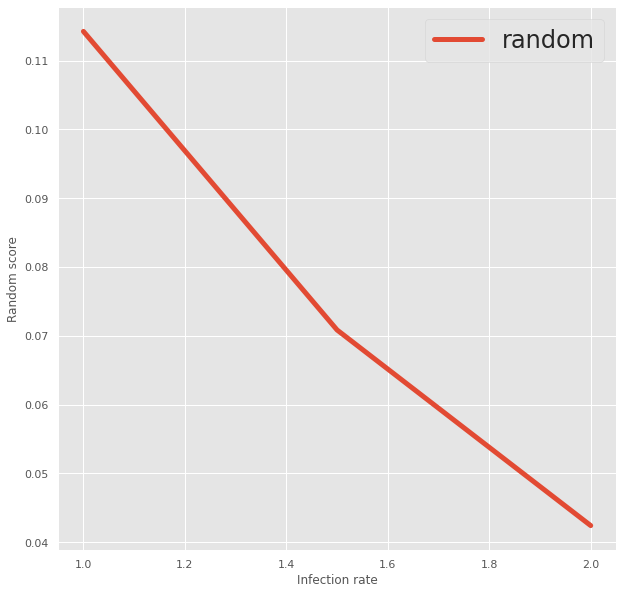

In [10]:
plt.style.use('ggplot')
for (baseline_name, result_item_list) in baseline_dict.items():
    if baseline_name != 'random':
        continue
    data = defaultdict(list)
    
    for ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) in result_item_list:
        data[inf_rate].append(result_data["score_mean"])
    
    data = [(ir,np.mean(s)) for ir,s in data.items()]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=baseline_name,linewidth=5)
    
plt.legend(prop={'size':24})
plt.xlabel('Infection rate')
plt.ylabel('Random score')
plt.show()

#### budget/infected vs. score
##### How much more vaccines than infecteds (as a ratio) do we have, and how did that affect end score?

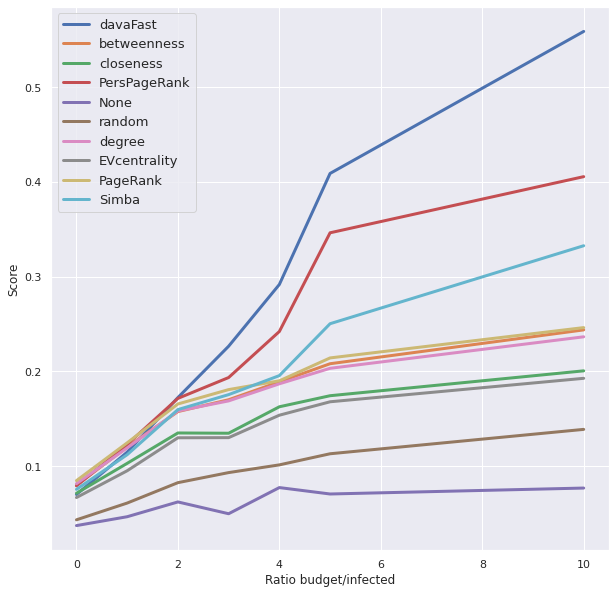

In [11]:
import seaborn as sns
sns.set()

for (baseline_name, result_item_list) in baseline_dict.items():
    #if baseline_name == 'random':
     #   continue
    data_p = defaultdict(list)
    for ((inf_rate,graph_name, baseline_name,infected_fraction,budget_fraction),(graph_data,result_data)) in result_item_list:
        data_p[int(1*budget_fraction/infected_fraction)].append(result_data["score_mean"])
    
   
    data_p = [(ratio/1,np.mean(s)) for ratio,s in data_p.items()]
    
    data_p.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data_p), label=baseline_name, linewidth=3)
    
plt.legend(prop={'size':13})
plt.xlabel('Ratio budget/infected')
plt.ylabel('Score')
plt.show()

### Dynamic information vs score
The following experiments looks at the gathered information about the graphs that depends on the location of the initially infected nodes.

Ideally, we would find one property of the initially infected nodes that shows how easy or hard vaccinating is, independent of the graph structure. But sadly, that is not the case.

dyn_eccentricity


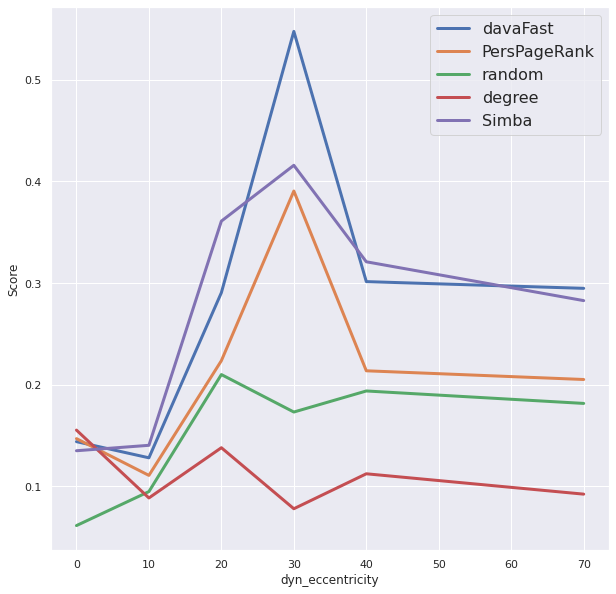

dyn_PersPR


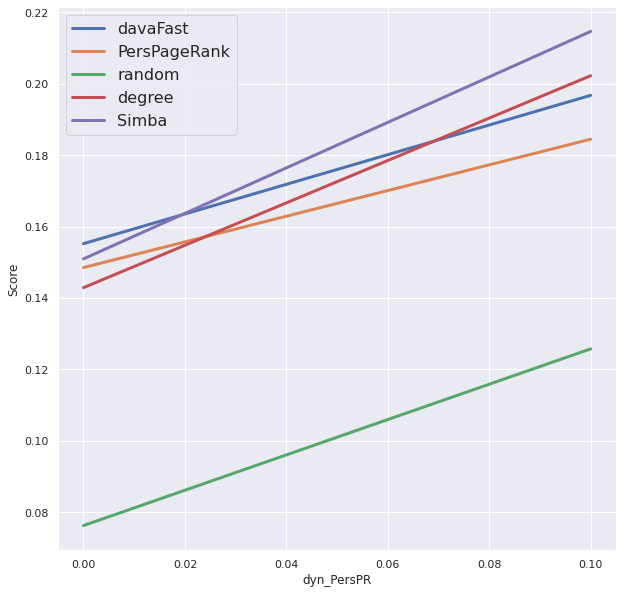

dyn_clustering


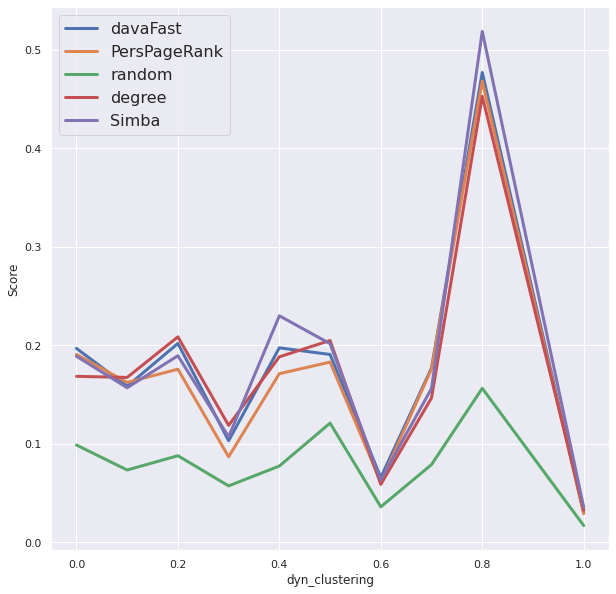

In [12]:
import seaborn as sns
sns.set()
for dyn_property in ["dyn_eccentricity","dyn_PersPR","dyn_clustering"]:
    plt.clf()
    print(dyn_property)
    for (baseline_name, result_item_list) in baseline_dict.items():
        if baseline_name not in ["Simba", "davaFast", "PersPageRank", "degree", "random"]:
            continue
        data_p = defaultdict(list)
        scale_factor = 10 if dyn_property != 'dyn_eccentricity' else 0.1
        for ((inf_rate,graph_name, baseline_name,infected_fraction,budget_fraction),(graph_data,result_data)) in result_item_list:
            data_p[int(scale_factor*graph_data[dyn_property])].append(result_data["score_mean"])


        data_p = [(ratio/scale_factor,np.mean(s)) for ratio,s in data_p.items()]

        data_p.sort(key=lambda x:x[0])
        plt.plot(*zip(*data_p), label=baseline_name, linewidth=3)
    
    plt.legend(prop={'size':16})
    plt.xlabel(dyn_property)
    plt.ylabel('Score')
    plt.show()

### Performance by Graphs:

Takeaway: DAVA makes the most use of having a large amount of vaccines (relative to the amount of initially infected nodes).

geom_graph


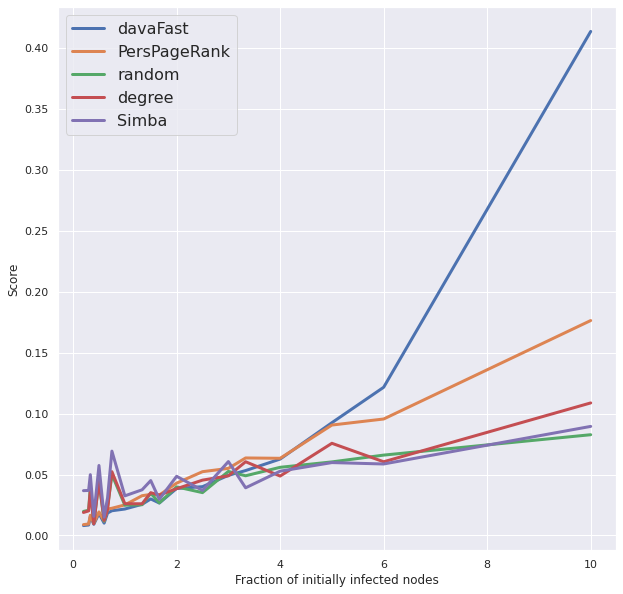

newman


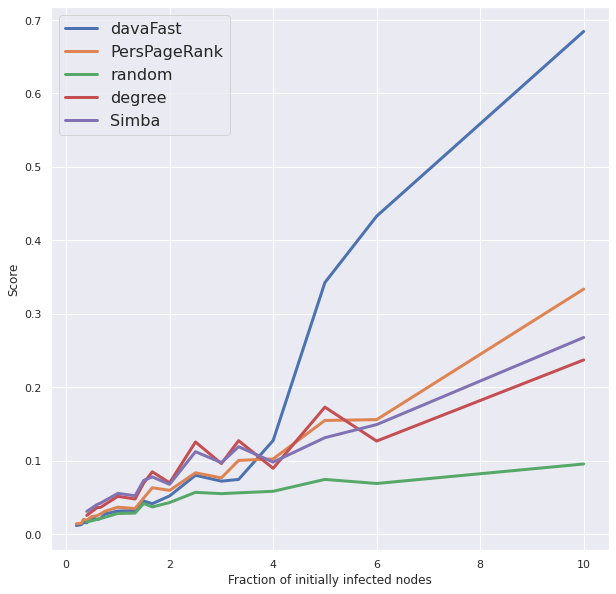

regular


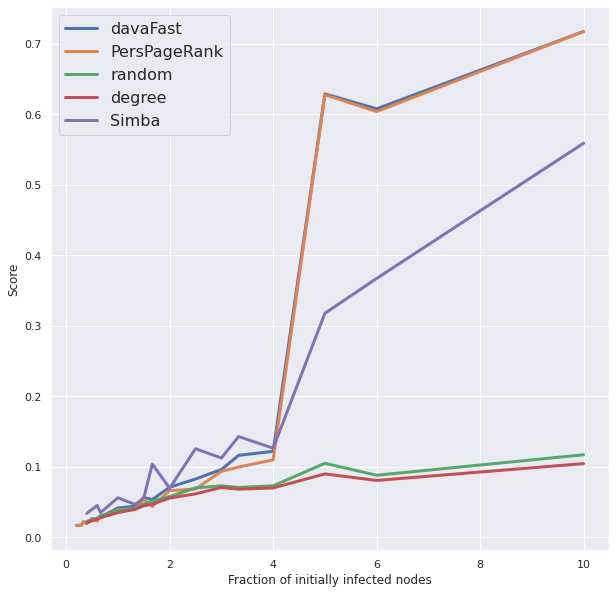

householdsuper


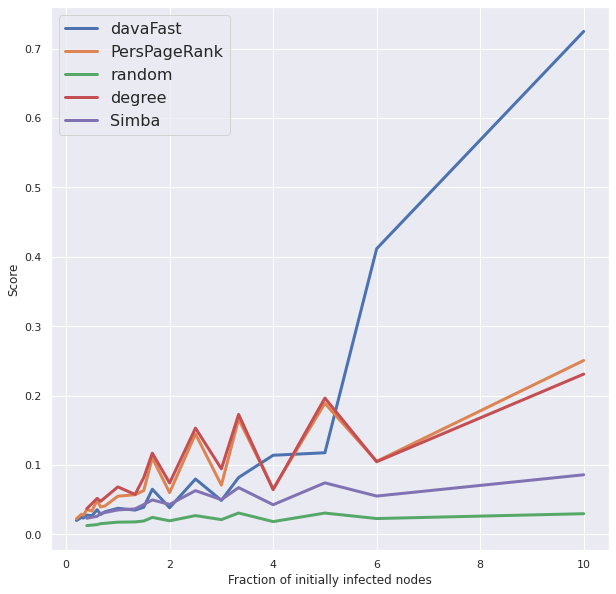

erdos_renyi


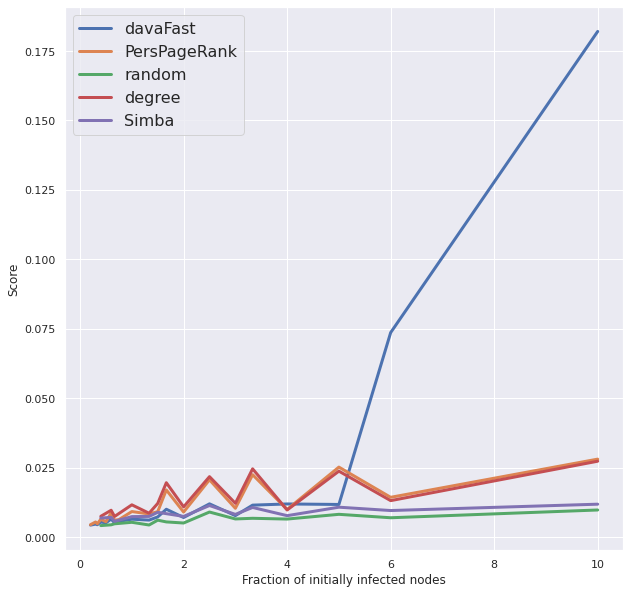

barabasi


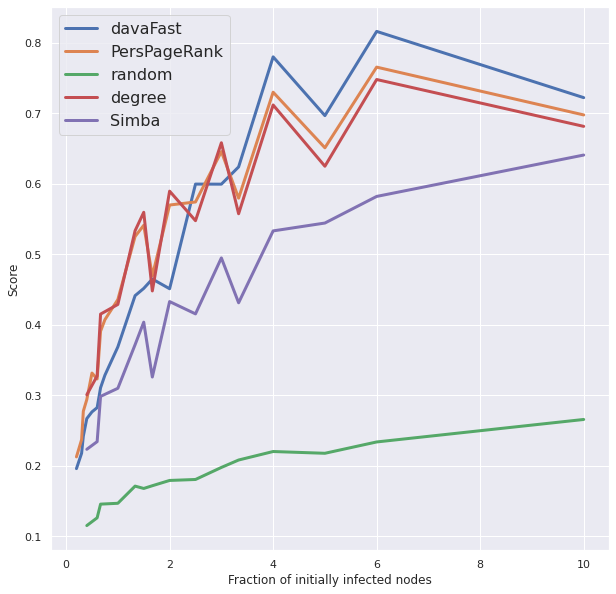

grid_2d


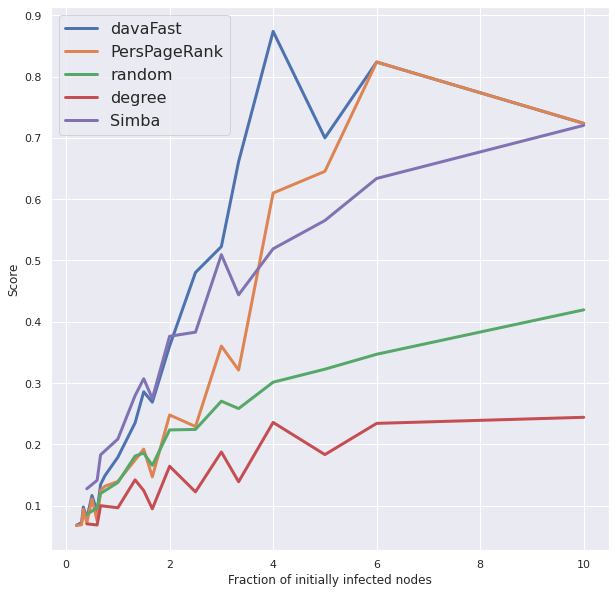

In [13]:
def list_to_dict(results_list):
    results = {}
    
    for ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) in results_list:
        results[(inf_rate,graph_name, baseline_name,infected_fraction,budget)] = (graph_data,result_data)
    
    return results

for (graph_prefix, result_item_list) in graph_dict.items():
    if graph_prefix=="complete":
        continue
    print(graph_prefix)
    results_x = list_to_dict(result_item_list)
    baseline_dict_2 = extract_by_baseline(results_x)
    for (baseline_name, result_item_list) in baseline_dict_2.items():
        if baseline_name not in ["Simba", "PersPageRank", "degree", "random", "davaFast"]:
            continue
        data_p = defaultdict(list)
        for ((inf_rate,graph_name, baseline_name,infected_fraction,budget_fraction),(graph_data,result_data)) in result_item_list:
            data_p[int(1000*budget_fraction/infected_fraction)].append(result_data["score_mean"])


        data_p = [(ratio/1000,np.mean(s)) for ratio,s in data_p.items()]

        data_p.sort(key=lambda x:x[0])

        
        plt.plot(*zip(*data_p), label=baseline_name, linewidth=3)
    
    plt.legend(prop={'size':16})
    plt.xlabel('Fraction of initially infected nodes')
    plt.ylabel('Score')
    plt.show()

# Testing out a simpler version of Simba
In this section, the performance of a simpler version of Simba is tested. In this method, dubbed SimbaSimple, the nodes of the transition graph that have the highest "intensity" are vaccinated. Intensity denotes the probability of infection across the simulations.

In [14]:
run_nr=789789
number_of_parallel_runs=8

results = {}
for no in range(number_of_parallel_runs):
    path = "output/benchmark/{run_nr}/results_{no}.pickle".format(run_nr=run_nr,no=no)
    try:
        with open(path, 'rb') as handle:
            results = {**results,**pickle.load(handle)} # combine dicts from different parallel runs
    except:
        print("Error!")
        pass
        

Error!


In [15]:
extracted_means = {}
baseline_dict = extract_by_baseline(results)
for (baseline_name, result_item_list) in baseline_dict.items():
    scores = [ri[1][1]["score_mean"] for ri in result_item_list]
    extracted_means[baseline_name] = np.mean(scores)

extracted_means = sorted(extracted_means.items(),key=lambda x: x[1], reverse=True)

for name, mean_score in extracted_means:
    print(name,":\t", mean_score)

Simba :	 0.17021579849746388
SimbaSimple :	 0.13242718182707355
random :	 0.07976338068596765
None :	 0.0526291676906881


geom_graph


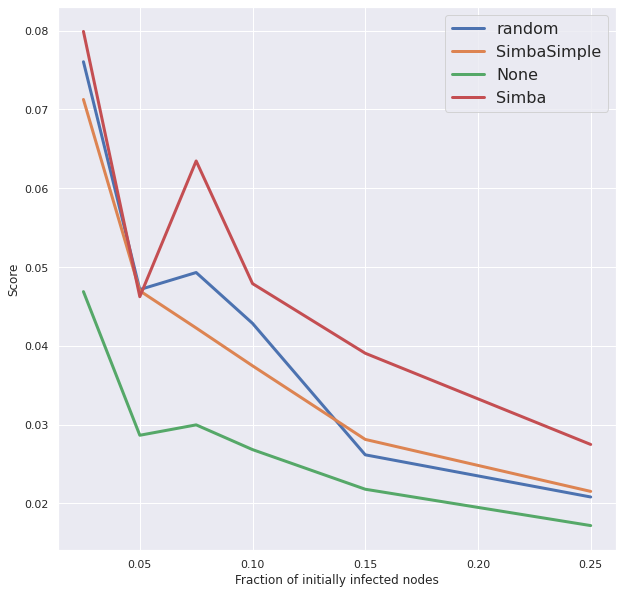

newman


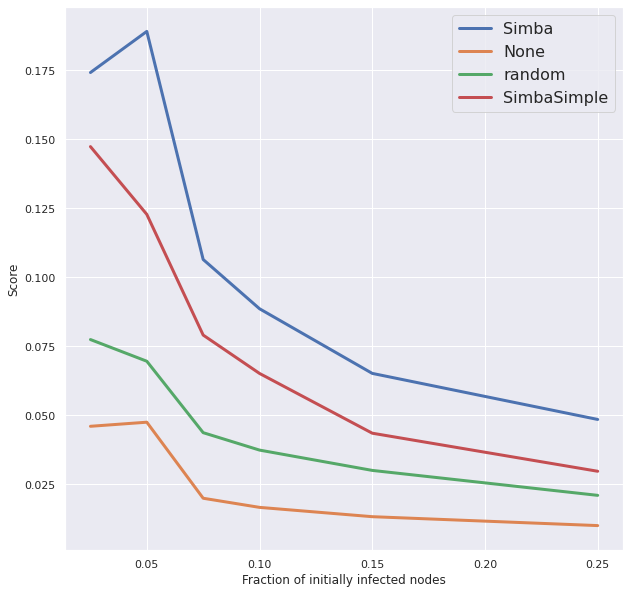

regular


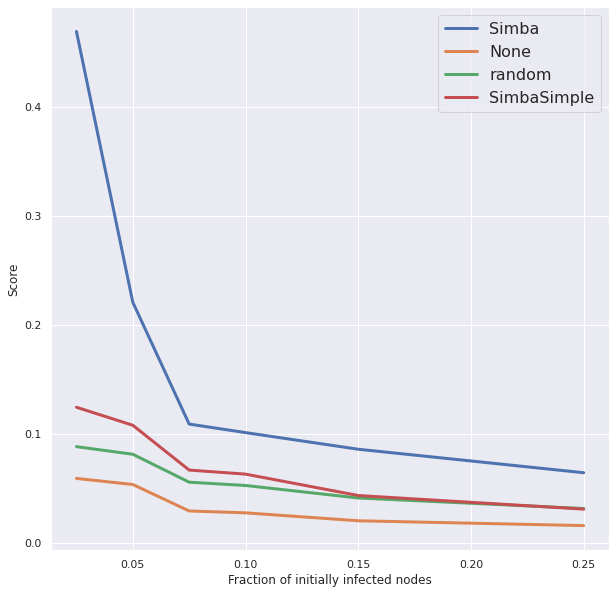

householdsuper


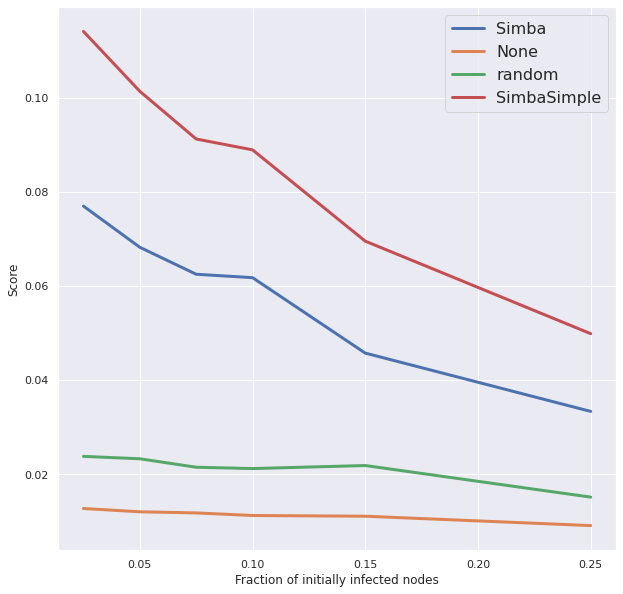

erdos_renyi


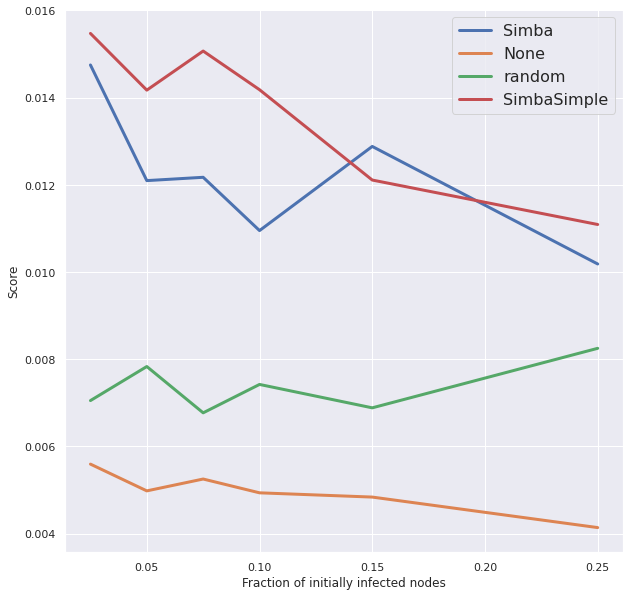

barabasi


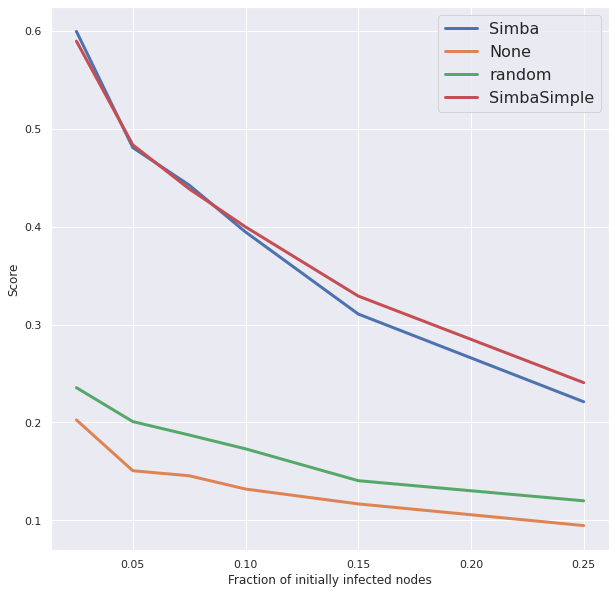

grid_2d


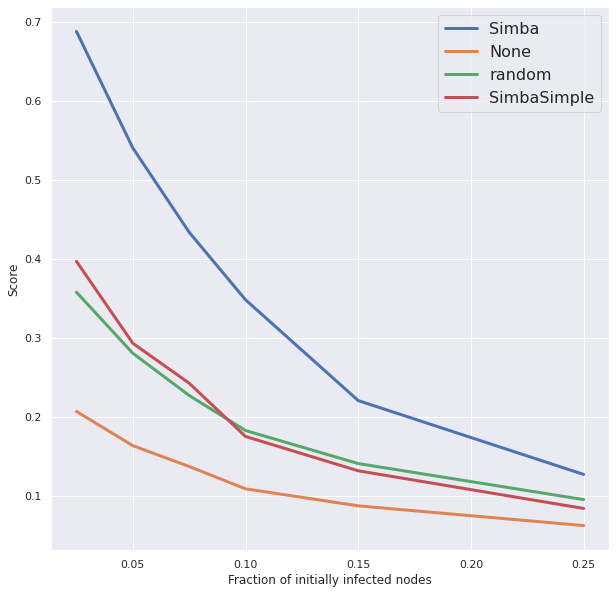

In [18]:
def list_to_dict(results_list):
    results = {}
    
    for ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) in results_list:
        results[(inf_rate,graph_name, baseline_name,infected_fraction,budget)] = (graph_data,result_data)
    
    return results

graph_dict = extract_by_graph(results)

for (graph_prefix, result_item_list) in graph_dict.items():
    if graph_prefix == "complete":
        continue
    print(graph_prefix)
    results_x = list_to_dict(result_item_list)
    baseline_dict_2 = extract_by_baseline(results_x)
    for (baseline_name, result_item_list) in baseline_dict_2.items():
        if baseline_name not in ["Simba", "SimbaSimple", "None", "random", ]:
            continue
        data_p = defaultdict(list)
        for ((inf_rate,graph_name, baseline_name,infected_fraction,budget_fraction),(graph_data,result_data)) in result_item_list:
            data_p[int(1000*infected_fraction)].append(result_data["score_mean"])


        data_p = [(ratio/1000,np.mean(s)) for ratio,s in data_p.items()]

        data_p.sort(key=lambda x:x[0])

        
        plt.plot(*zip(*data_p), label=baseline_name, linewidth=3)
    
    plt.legend(prop={'size':16})
    plt.xlabel('Fraction of initially infected nodes')
    plt.ylabel('Score')
    plt.show()